In [1]:
import sys 
sys.path.append('..')
from utils import wasserstein2
from kernels import *
from distributions import *
from kernelGAN import *
import torch, matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

device = torch.device('cpu')
%matplotlib inline
plt.rcParams.update({'font.size': 20})
%load_ext autoreload
%autoreload 2

## Setting up 1D Scenario
One generated and one true target

In [9]:
# distribution params
n_true, n_gen, d = 1, 1, 1
n_mixture, sigma = 0, 0

# initializing points
X_true = torch.tensor([[0]], dtype=torch.float32)
X_gen_init = torch.tensor([[0.1]], dtype=torch.float32)
p_gen = torch.randn(n_gen).softmax(-1)
p_true = torch.randn(n_true).softmax(-1)

### Multiscale Kernel Sim

In [10]:
# varying across training params
T = 1000
width_params=[0.1, 1, 10]
lr_combos = [(1,0.1),(0.1,0.1), (0.1, 0.01), (0.01,0.01)] #(lr_d,lr_g)
lams = [1, 1e-1, 1e-2]
log_interval=10

W_dist = np.zeros((len(lr_combos), len(lams), len(width_params), T//log_interval))
for k, width_param in enumerate(width_params):
    # init kernel
    DK = Kernel('gaussian', width_param=width_param)
    for i, (lr_d,lr_g) in enumerate(lr_combos):
        for j, lam in enumerate(lams):
            # init generator + discriminator
            G = PointGenerator(X_gen_init, p_gen)
            D = KernelDiscriminator(DK,d, lam, lr_d)
            # find generated trajectories
            model = KernelGAN(G, D, device)
            model.train(X_true, p_true, lr_d, lr_g, T, lam)
            # calculate w2 distances
            curr_w2 = wasserstein2(model.G.X_gen.detach().cpu(), X_true.detach().cpu(), log_interval)
            W_dist[i, j, k, :] = curr_w2

100%|██████████| 100/100 [00:00<00:00, 1781.41it/s]


### ODE Approximations

In [11]:
Xhistlin = np.zeros((len(lr_combos), len(lams), len(width_params), T))
Xhistquad = np.zeros((len(lr_combos), len(lams), len(width_params), T))
Xhistavg = np.zeros((len(lr_combos), len(lams), len(width_params), T))

for k, width_param in enumerate(tqdm(width_params)):
    gam = 1/(width_param**2)
    for i, (lr_d,lr_g) in enumerate(lr_combos):
        for j, lam in enumerate(lams):
            # initializing linear model
            xglin = X_gen_init
            bl = 0
            # initializing quadratic model
            xgquad = X_gen_init
            bq = 0
            cq = 0
            # Averaged model
            xavg = X_gen_init/2
            cavg = 0
            for it in range(T):
                # Linear Model
                dbl = -lam*bl - gam*xglin
                bl = bl + lr_d*dbl
                xglin = xglin + lr_g*bl
                Xhistlin[i,j,k,it] = xglin
                
                # Quadratic model
                dbq = -lam*bq - xgquad*gam
                dcq = -lam*cq + 1.5*(gam*xgquad)**2
                bq = bq + lr_d*dbq 
                cq = cq + lr_d*dcq
                Xhistquad[i,j,k,it] = xgquad
                xgquad = xgquad + lr_g*(bq - cq*xgquad)                
                
                # Time-averaged model
                mu = lr_g/lr_d    
                dcavg = -lam*cavg + 1.5*(gam*xavg)**2
                dxavg = -(lam + mu*cavg)*xavg
                xavg = xavg + lr_d*dxavg
                cavg = cavg + lr_d*dcavg 
                Xhistavg[i,j,k,it] = xavg


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


## Plotting

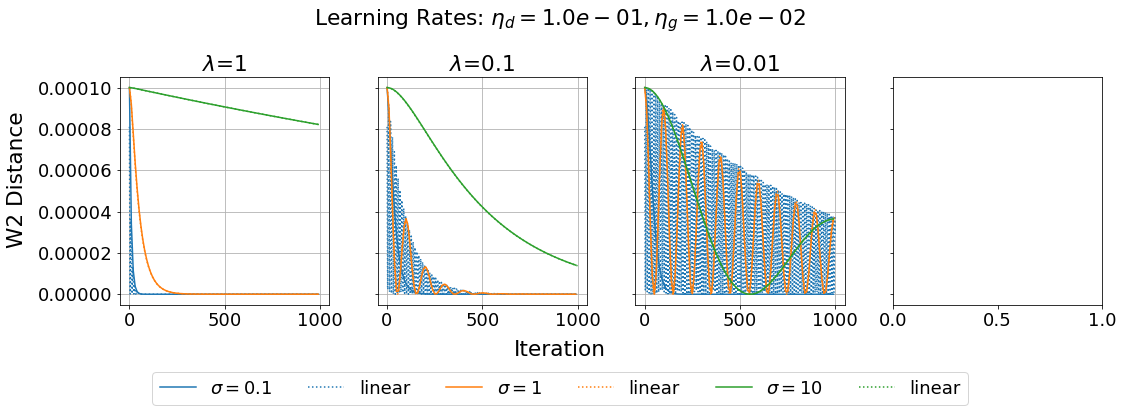

In [5]:
lr_index=2
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,4,figsize=(16,5), sharey=True)
for j, lam in enumerate(lams):
    # curr_ax = ax[j//2,j%2]
    curr_ax =  ax[j]
    curr_ax.set_title(f'$\lambda$={lam}')
    curr_ax.grid()
    for k, width_param in enumerate(width_params):
        curr_ax.plot(list(range(0,T,log_interval)), W_dist[lr_index,j, k,:], c=f'C{k}', label=f'$\sigma=${width_param}')
        curr_ax.plot(list(range(0,T)), Xhistlin[lr_index,j, k,:]**2, c=f'C{k}', label=f'linear', ls='dotted')
        # curr_ax.semilogy(list(range(0,T)), Xhistquad[lr_index,j, k,:]**2, c=f'C{k}', label=f'quadratic', ls='dotted')
        # curr_ax.semilogy(list(range(0,T)), Xhistavg[lr_index,j, k,:]**2, c=f'C{k}', label=f'avg', ls='dashed')
        # curr_ax.set_ylim((10**-14,10**3))
# ax[3].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
handles, labels = ax[0].get_legend_handles_labels()
# fig.subplots_adjust(bottom=0.1)
fig.legend(labels=labels, bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=6)
fig.tight_layout(rect=[0.03, 0.03, 1, 0.90])
fig.supylabel('W2 Distance')
fig.supxlabel('Iteration', y=-0)
fig.suptitle(f'Learning Rates: $\eta_d={lr_combos[lr_index][0]:.1e},\eta_g={lr_combos[lr_index][1]:.1e}$')
# plt.savefig(f"../data/twopoint_lr{lr_index}_ODEoverlay.png", format='png', bbox_inches='tight')
plt.show()

Text(0.02, 0.5, '$\\ell_2$ Distance')

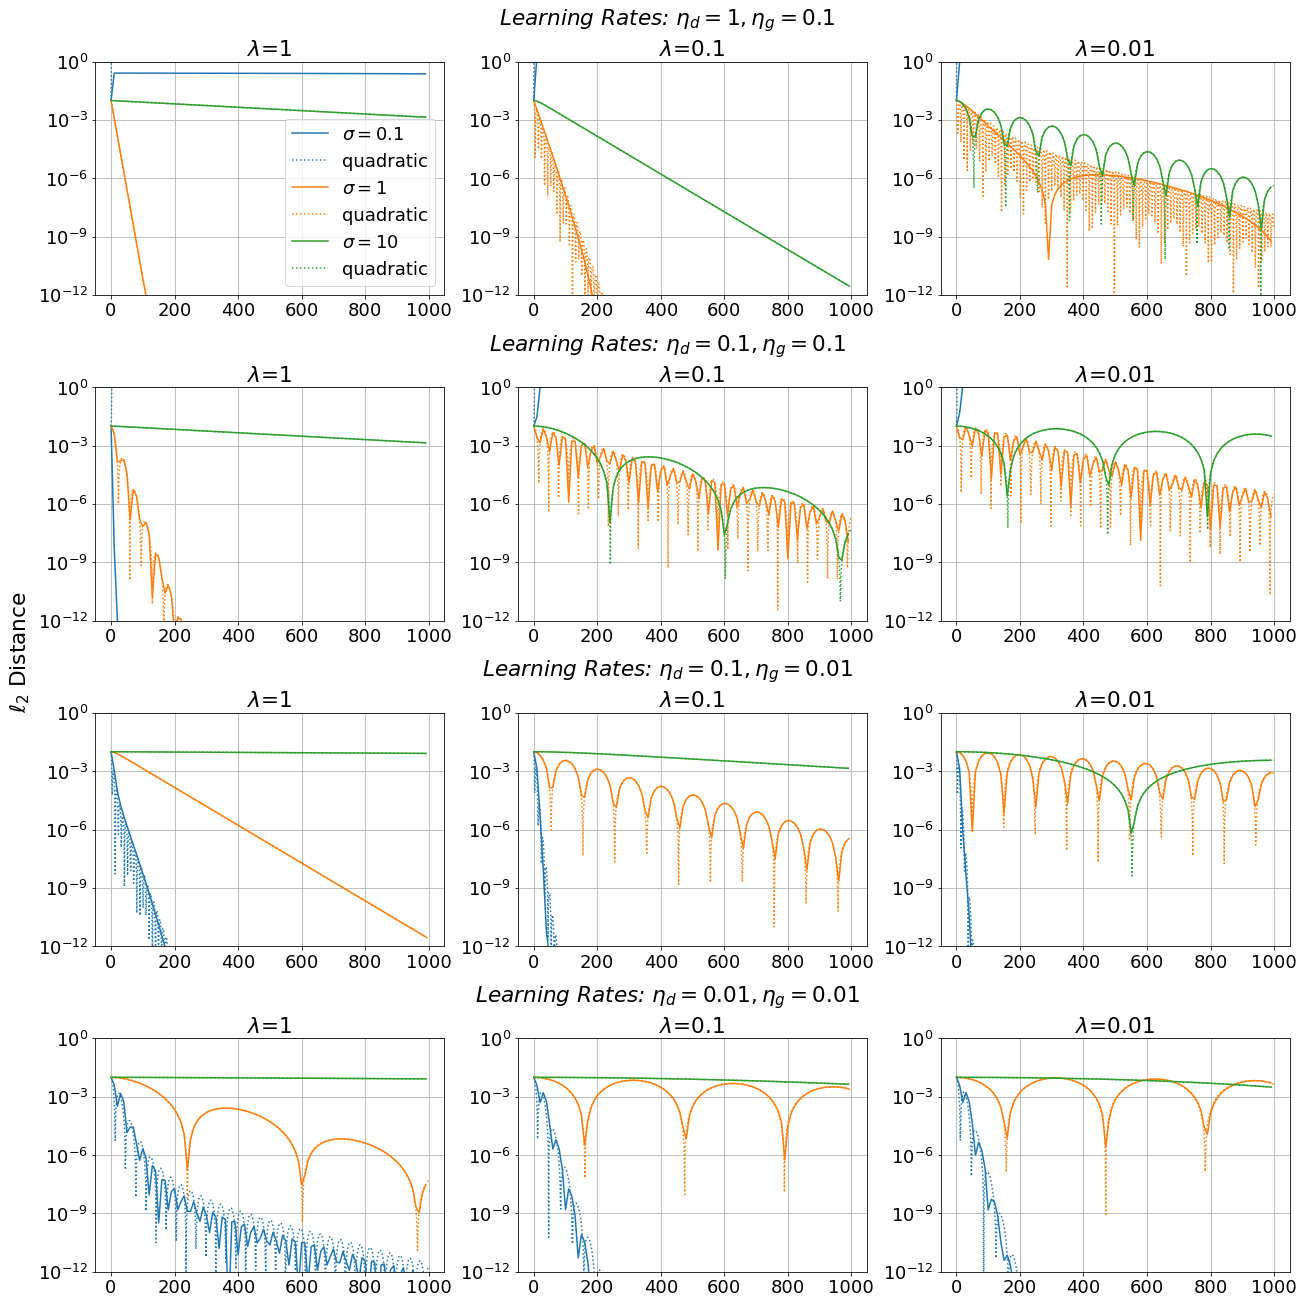

In [12]:
fig = plt.figure(figsize=(18,18), constrained_layout=True)
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=4, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'Learning Rates: $\eta_d={lr_combos[row][0]},\eta_g={lr_combos[row][1]}$',
                    style='italic')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        for k, width_param in enumerate(width_params):
            ax.semilogy(list(range(0,T,log_interval)), W_dist[row,col, k,:], c=f'C{k}', label=f'$\sigma=${width_param}')
            # ax.semilogy(list(range(0,T)), Xhistlin[row,col, k,:]**2, c=f'C{k}', label=f'linear', ls='dotted')
            ax.semilogy(list(range(0,T)), Xhistquad[row,col, k,:]**2, c=f'C{k}', label=f'quadratic', ls='dotted')
            # ax.semilogy(list(range(0,T)), Xhistavg[lr_index,j, k,:]**2, c=f'C{k}', label=f'avg', ls='dashed')
            ax.set_ylim((10**-12,10**0))
        ax.grid()
        ax.set_title(f'$\lambda$={lams[col]}')
        ax.plot()
        if row==0 and col==0:
            ax.legend(loc='lower right')
fig.supylabel('$\ell_2$ Distance')
# plt.savefig(f"../data/twopoint_param_scan.png", format='png', bbox_inches='tight')

## Optional Saving Data

In [ ]:
import pickle 

# store all W_dist histories into list of dictionaries
filename = '../data/test.pkl'
W2_list = []
list_to_str = lambda curr_list: '' if len(curr_list)==0 else f'_{curr_list[0]}{list_to_str(curr_list[1:])}'
for i, (lr_d, lr_g) in enumerate(lr_combos):
    for j, lam in enumerate(lams):
        for k, width_param in enumerate(width_params):
            W2_list.append({'lr_g':lr_g, 'lr_d':lr_d, 'lam':lam, 'width_param':width_param, 'W_dist':W_dist[i, j, k,:]})

with open(filename, 'wb') as f:
    pickle.dump(W2_list, f)
with open(filename, 'rb') as f:
    loaded_W2_list = pickle.load(f)